# HT dei modelli, riallenamento e valutazione del migliore

In [3]:
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, average_precision_score, auc, brier_score_loss, matthews_corrcoef, roc_auc_score, roc_curve, precision_recall_curve
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV
import pickle
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [6]:
sentinels = ['None', 'n.d.', ' ', '']
df = pd.read_csv('assets/yid_out.tsv', sep='\t', na_values=sentinels)

In [7]:
df.valoreIntero.fillna(df.valoreIntero.mean(), inplace=True)
df.mediaVoto.fillna(df.mediaVoto.mean(), inplace=True)
df.votoDiploma.fillna(round(df.votoDiploma.mean()), inplace=True)


df = df.drop(['luogoDiNascita', 'nazioneNascita'], axis=1)
df = df.astype({'valoreIntero': np.int64, 'votoDiploma': np.int32})
# print(pd.isnull(df).sum() > 0)
print(df.shape)

(70018, 24)


In [8]:
y = df.Dropout
X = df.drop(['ID_Stud', 'Dropout', 'lastLogin', 'annoAccaCors'], axis = 1) # , 'ultIscr', 'creditiTotali', 'ultPren', 'ultSup'
# print(X.head())

val = {True: 1, False: 0}
X["sesso"] = X["sesso"].map(val)
X = X.astype({ 'sesso': np.int32})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
print("Training Set shape: {}".format(X_train.shape))
print("Test Set shape: {}".format(X_test.shape))

Training Set shape: (56014, 20)
Test Set shape: (14004, 20)


In [5]:
ohe_elements =  ['cittadinanza', 'facolta', 'tipoIscrizione']
encoder = OneHotEncoder(handle_unknown="ignore")
feature_arr = encoder.fit_transform(X_train[ohe_elements]).toarray()
feature_labels = encoder.get_feature_names_out()
feature_labels = np.array(feature_labels).ravel()
encoded_df = pd.DataFrame(feature_arr, columns=feature_labels)
X_train = X_train.reset_index(drop=True)
X_train = X_train.join(encoded_df)
X_train = X_train.drop(ohe_elements, axis=1)
with open('assets/encoder.pickle', 'wb') as f:
    pickle.dump(encoder, f)
X_train.head()

,annoCorso,eta,codCorso,creditiTotali,flagIdentificato,primaIscr,sesso,tipoCorso,tipoStudente,ultIscr,...,facolta_LETTERE E FILOSOFIA,facolta_MEDICINA E ODONTOIATRIA,facolta_MEDICINA E PSICOLOGIA,"facolta_SCIENZE MATEMATICHE, FISICHE E NATURALI","facolta_SCIENZE POLITICHE, SOCIOLOGIA, COMUNICAZIONE",facolta_SCUOLA DI INGEGNERIA AEROSPAZIALE,tipoIscrizione_FUORI CORSO,tipoIscrizione_IMMATRICOLAZIONE,tipoIscrizione_IN CORSO,tipoIscrizione_RIPETENTE
0,2,24,30822,120,1,2,1,28,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,25,30071,120,0,2,1,28,2,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,3,23,29850,180,1,4,0,27,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,23,29850,180,1,4,0,27,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,26,29949,180,0,2,1,27,2,2,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [6]:
ohe_elements =  ['cittadinanza', 'facolta', 'tipoIscrizione']
with open('assets/encoder.pickle', 'rb') as f:
    encoder = pickle.load(f)


feature_arr = encoder.transform(X_test[ohe_elements]).toarray()
feature_labels = encoder.get_feature_names_out()
feature_labels = np.array(feature_labels).ravel()
encoded_df = pd.DataFrame(feature_arr, columns=feature_labels)
X_test = X_test.reset_index(drop=True)
X_test = X_test.join(encoded_df)
X_test = X_test.drop(ohe_elements, axis=1)

X_test.head()

,annoCorso,eta,codCorso,creditiTotali,flagIdentificato,primaIscr,sesso,tipoCorso,tipoStudente,ultIscr,...,facolta_LETTERE E FILOSOFIA,facolta_MEDICINA E ODONTOIATRIA,facolta_MEDICINA E PSICOLOGIA,"facolta_SCIENZE MATEMATICHE, FISICHE E NATURALI","facolta_SCIENZE POLITICHE, SOCIOLOGIA, COMUNICAZIONE",facolta_SCUOLA DI INGEGNERIA AEROSPAZIALE,tipoIscrizione_FUORI CORSO,tipoIscrizione_IMMATRICOLAZIONE,tipoIscrizione_IN CORSO,tipoIscrizione_RIPETENTE
0,2,22,30425,180,1,2,1,27,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,21,30425,180,1,2,1,27,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,5,24,26694,300,1,6,0,23,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2,26,11028,0,1,2,1,20,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2,23,30820,180,1,2,1,27,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [7]:
if "facolta_PSICOLOGIA 1" in X_train.columns:
    X_train = X_train.drop(['facolta_PSICOLOGIA 1'], axis=1)
    X_test = X_test.drop(['facolta_PSICOLOGIA 1'], axis=1)

### Random Forest

In [19]:
# Number of trees in random forest
# Number of features to consider at every split
# Maximum number of levels in tree
# Minimum number of samples required at each leaf node
parameters = {'n_estimators': [250, 500, 1000],
                'class_weight': ["balanced", "balanced_subsample"],
                'max_features': ['auto', 'log2', None],
                'max_depth': [2, 4, 8, 12],
                'min_samples_leaf': [16, 32, 64, 128]}

rf = RandomForestClassifier()
rf_search = HalvingGridSearchCV(rf, parameters, n_jobs = -1, scoring = 'roc_auc')
# rf_search = RandomizedSearchCV(rf, parameters, n_jobs = -1, scoring = ['balanced_accuracy', 'average_precision', 'f1', 'roc_auc'], refit = 'roc_auc', n_iter=20)
rf_search.fit(X_train, y_train)

print(rf_search.best_params_)
print(rf_search.best_score_)

{'class_weight': 'balanced_subsample', 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 16, 'n_estimators': 1000}
0.9806906880776367


Confusion matrix:
 [[9281  727]
 [ 313 3686]]
Balanced Accuracy Score:  0.9245442730586724
Score:  0.9257514100092811
Brier score:  0.054050237495950816
Matthews corrcoef:  0.8255350406977316
Classification report:
               precision    recall  f1-score   support

       False       0.97      0.93      0.95     10008
        True       0.84      0.92      0.88      3999

    accuracy                           0.93     14007
   macro avg       0.90      0.92      0.91     14007
weighted avg       0.93      0.93      0.93     14007



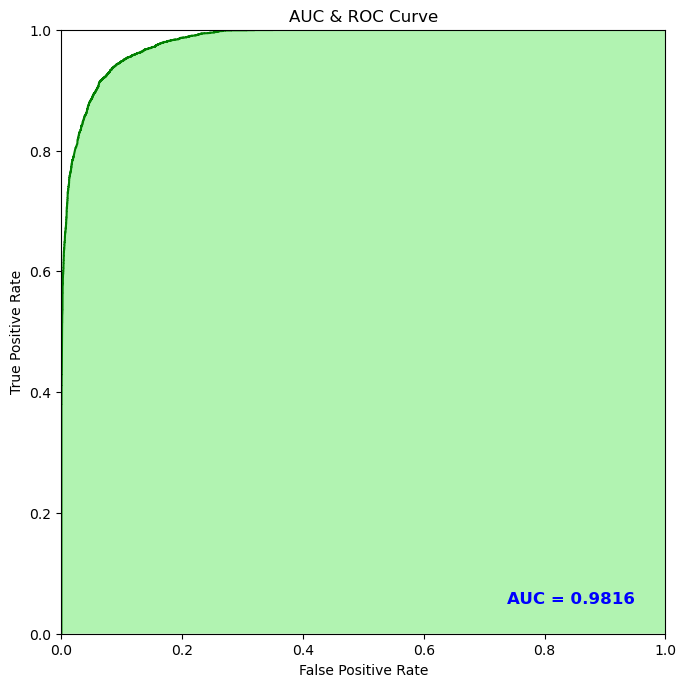

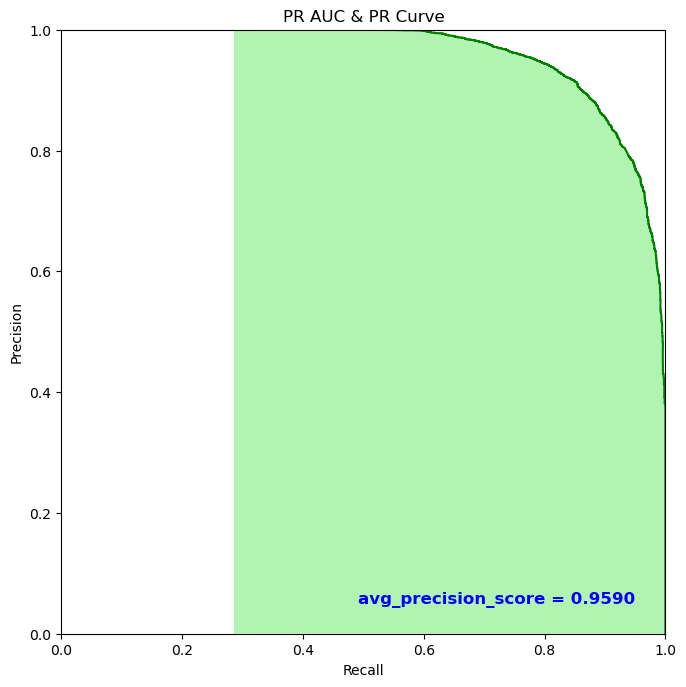

In [20]:
y_prob = rf_search.best_estimator_.predict_proba(X_test)[:,1]
y_pred = rf_search.best_estimator_.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

bas = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy Score: ", bas)

s = rf_search.best_estimator_.score(X_test, y_test)
print("Score: ", s)

bscore = brier_score_loss(y_test, y_prob)
print("Brier score: ", bscore)

mcc = matthews_corrcoef(y_test, y_pred)
print("Matthews corrcoef: ", mcc)

print("Classification report:\n", classification_report(y_test, y_pred))
auc = roc_auc_score(y_test, y_prob)

prauc = average_precision_score(y_test, y_prob)
precision, recall, _ = precision_recall_curve(y_test, y_prob)

false_positive_rate, true_positive_rate, thresolds = roc_curve(y_test, y_prob)

if len(true_positive_rate) < len(recall):
        tpr = np.append(true_positive_rate, (len(recall)-len(true_positive_rate)) * [None])
        fpr = np.append(false_positive_rate, (len(recall)-len(false_positive_rate)) * [None])
        tmp = pd.DataFrame.from_dict({'BAS': bas, 'simplyScore': s, 'brier': bscore, 'matthews': mcc, 'TPR' : tpr, 'FPR': fpr,
        'valAUC': auc, 'precision': precision, 'recall': recall, 'valPRAUC': prauc, 'method': 'RF'})
        tmp = tmp.astype({'TPR': np.float64, 'FPR': np.float64})
else:
    tmp = pd.DataFrame.from_dict({'BAS': bas, 'simplyScore': s, 'brier': bscore, 'matthews': mcc, 'TPR' : true_positive_rate, 'FPR': false_positive_rate,
    'valAUC': auc, 'precision': precision, 'recall': recall, 'valPRAUC': prauc, 'method': 'RF'})

tmp.to_csv('assets/auc_res.tsv', index = False, sep='\t', header=None, mode='a', float_format='%.18f', na_rep='')

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("PR AUC & PR Curve")
plt.plot(precision, recall, 'g')
plt.fill_between(precision, recall, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'avg_precision_score = %0.4f' % prauc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

### Gradient Boosting Decision Tree

In [14]:
parameters = {'loss': ['deviance', 'exponential'],
                'n_estimators': [250, 500, 1000],
                "max_depth": [2, 4, 8, 12],
                'min_samples_leaf': [16, 32, 64, 128],
                'learning_rate': [0.01, 0.05, 0.1, 1, 10],
                'max_features': ['auto', 'sqrt', None]}
gb = GradientBoostingClassifier()
gb_search = HalvingGridSearchCV(gb, parameters, n_jobs = -1, scoring = 'roc_auc')
# gb_search = RandomizedSearchCV(gb, parameters, n_jobs = -1, scoring = ['balanced_accuracy', 'average_precision', 'f1', 'roc_auc'], refit = 'roc_auc', n_iter=20)
gb_search.fit(X_train, y_train)

print(gb_search.best_params_)
print(gb_search.best_score_)

{'learning_rate': 0.01, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 16, 'n_estimators': 500}
0.9836727187646455


Confusion matrix:
 [[9641  367]
 [ 554 3445]]
Balanced Accuracy Score:  0.9123973514361804
Score:  0.9342471621332191
Brier score:  0.04589604194969012
Matthews corrcoef:  0.8369994111543103
Classification report:
               precision    recall  f1-score   support

       False       0.95      0.96      0.95     10008
        True       0.90      0.86      0.88      3999

    accuracy                           0.93     14007
   macro avg       0.92      0.91      0.92     14007
weighted avg       0.93      0.93      0.93     14007



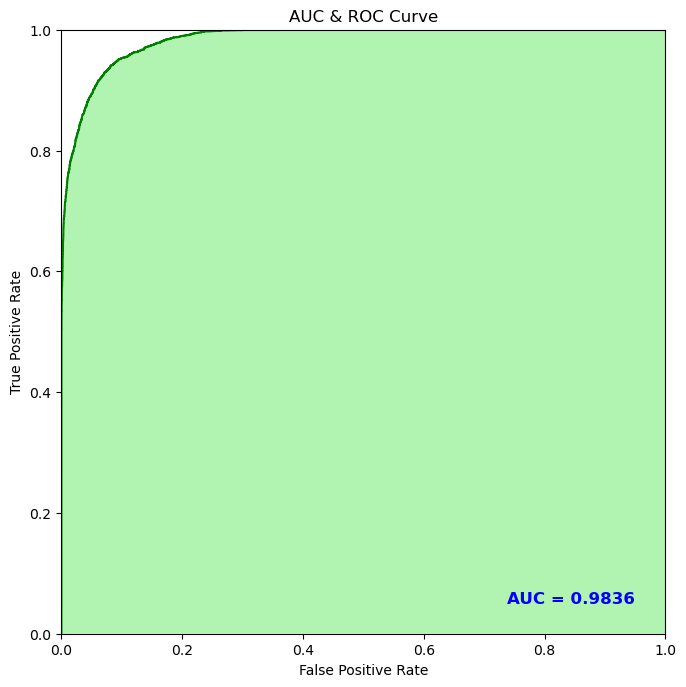

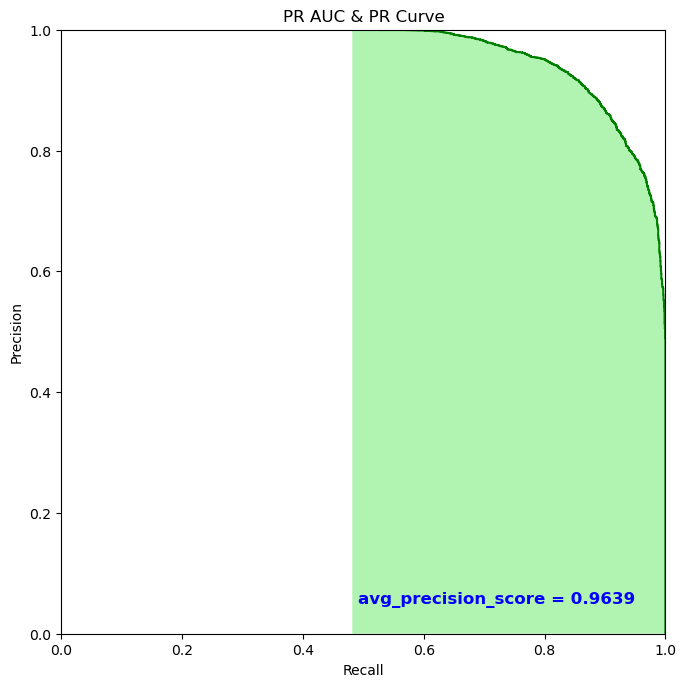

In [15]:
y_pred = gb_search.best_estimator_.predict(X_test)
y_prob = gb_search.best_estimator_.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

bas = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy Score: ", bas)

s = gb_search.best_estimator_.score(X_test, y_test)
print("Score: ", s)

bscore = brier_score_loss(y_test, y_prob)
print("Brier score: ", bscore)

mcc = matthews_corrcoef(y_test, y_pred)
print("Matthews corrcoef: ", mcc)

print("Classification report:\n", classification_report(y_test, y_pred))
auc = roc_auc_score(y_test, y_prob)

prauc = average_precision_score(y_test, y_prob)
precision, recall, _ = precision_recall_curve(y_test, y_prob)

false_positive_rate, true_positive_rate, thresolds = roc_curve(y_test, y_prob)

if len(true_positive_rate) < len(recall):
    tpr = np.append(true_positive_rate, (len(recall)-len(true_positive_rate)) * [None])
    fpr = np.append(false_positive_rate, (len(recall)-len(false_positive_rate)) * [None])
    tmp = pd.DataFrame.from_dict({'BAS': bas, 'simplyScore': s, 'brier': bscore, 'matthews': mcc, 'TPR' : tpr, 'FPR': fpr,
    'valAUC': auc, 'precision': precision, 'recall': recall, 'valPRAUC': prauc, 'method': 'GBDT'})
    tmp = tmp.astype({'TPR': np.float64, 'FPR': np.float64})
else:
    tmp = pd.DataFrame.from_dict({'BAS': bas, 'simplyScore': s, 'brier': bscore, 'matthews': mcc, 'TPR' : true_positive_rate, 'FPR': false_positive_rate,
    'valAUC': auc, 'precision': precision, 'recall': recall, 'valPRAUC': prauc, 'method': 'GBDT'})
tmp.to_csv('assets/auc_res.tsv', index = False, sep='\t', mode = 'a', header = None, float_format='%.18f')

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("PR AUC & PR Curve")
plt.plot(precision, recall, 'g')
plt.fill_between(precision, recall, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'avg_precision_score = %0.4f' % prauc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

### Serializing the best model

In [16]:
pickle.dump(gb_search.best_estimator_, open("assets/gbdt_model.pickle", "wb"))

### Logistic Regression

In [10]:
std_elements = ['codCorso', 'valoreIntero', 'creditiTotali',  'cfuPrenotati', 'cfuTake', 'mediaVoto']
X_train_std = X_train.copy()

scaler = MinMaxScaler()
X_train_std[std_elements] = scaler.fit_transform(X_train_std[std_elements])
pickle.dump(scaler, open("assets/scaler.pickle", "wb"))

X_train_std.head()

,annoCorso,eta,codCorso,creditiTotali,flagIdentificato,primaIscr,sesso,tipoCorso,tipoStudente,ultIscr,...,facolta_LETTERE E FILOSOFIA,facolta_MEDICINA E ODONTOIATRIA,facolta_MEDICINA E PSICOLOGIA,"facolta_SCIENZE MATEMATICHE, FISICHE E NATURALI","facolta_SCIENZE POLITICHE, SOCIOLOGIA, COMUNICAZIONE",facolta_SCUOLA DI INGEGNERIA AEROSPAZIALE,tipoIscrizione_FUORI CORSO,tipoIscrizione_IMMATRICOLAZIONE,tipoIscrizione_IN CORSO,tipoIscrizione_RIPETENTE
0,2,24,0.977258,0.333333,1,2,1,28,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,25,0.953203,0.333333,0,2,1,28,2,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,3,23,0.946124,0.500000,1,4,0,27,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,23,0.946124,0.500000,1,4,0,27,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,26,0.949295,0.500000,0,2,1,27,2,2,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [11]:
with open('assets/scaler.pickle', 'rb') as f:
    scaler = pickle.load(f)

X_test_std = X_test.copy()
X_test_std[std_elements] = scaler.transform(X_test_std[std_elements])

In [30]:
parameters = {#'penalty' : ['l1', 'l2', 'elasticnet', None],
                'C': [0.1, 0.5, 1, 50, 100],
                'class_weight': ['balanced', None],
                'solver': ['lbfgs','newton-cg','liblinear'],
                'max_iter' : [50, 100, 1000]}

lr = LogisticRegression()
lr_search = HalvingGridSearchCV(lr, parameters, n_jobs = -1, scoring = 'roc_auc')
# lr_search = RandomizedSearchCV(lr, parameters, n_jobs = -1, scoring = ['balanced_accuracy', 'average_precision', 'f1', 'roc_auc'], refit = 'roc_auc', n_iter=20)
lr_search.fit(X_train_std, y_train)

print(lr_search.best_params_)
print(lr_search.best_score_)

/home/andrea/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/andrea/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

{'C': 1, 'class_weight': 'balanced', 'max_iter': 50, 'solver': 'liblinear'}
0.9369896638411159


Confusion matrix:
 [[8560 1448]
 [ 388 3611]]
Balanced Accuracy Score:  0.8791457456690313
Score:  0.2855001070893125
Brier score:  0.0974293740580702
Matthews corrcoef:  0.7130011098343353
Classification report:
               precision    recall  f1-score   support

       False       0.96      0.86      0.90     10008
        True       0.71      0.90      0.80      3999

    accuracy                           0.87     14007
   macro avg       0.84      0.88      0.85     14007
weighted avg       0.89      0.87      0.87     14007



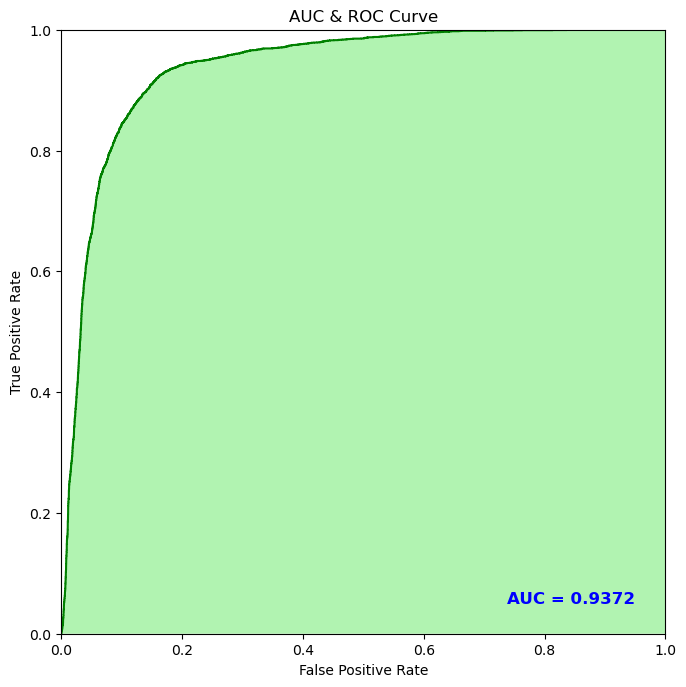

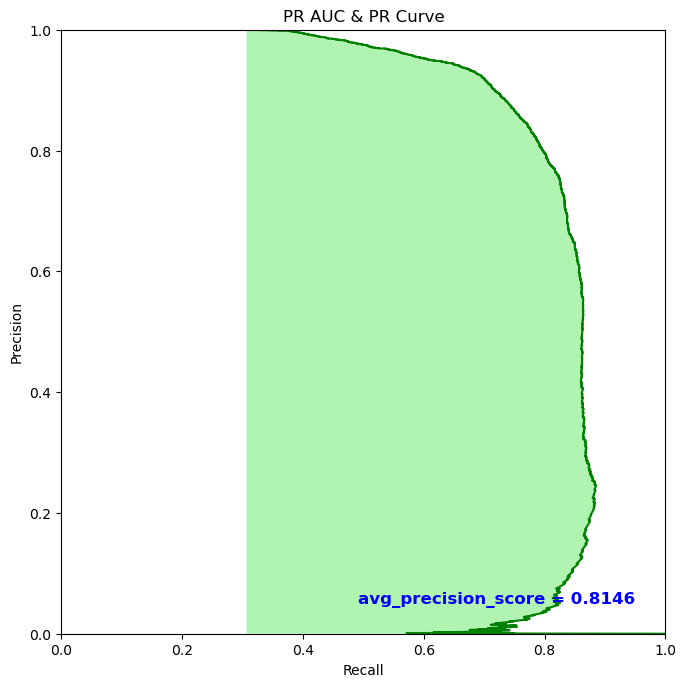

In [31]:
y_pred = lr_search.best_estimator_.predict(X_test_std)
y_prob = lr_search.best_estimator_.predict_proba(X_test_std)[:,1]

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

bas = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy Score: ", bas)

s = lr_search.best_estimator_.score(X_test, y_test)
print("Score: ", s)

bscore = brier_score_loss(y_test, y_prob)
print("Brier score: ", bscore)

mcc = matthews_corrcoef(y_test, y_pred)
print("Matthews corrcoef: ", mcc)

print("Classification report:\n", classification_report(y_test, y_pred))
auc = roc_auc_score(y_test, y_prob)

prauc = average_precision_score(y_test, y_prob)
precision, recall, _ = precision_recall_curve(y_test, y_prob)

false_positive_rate, true_positive_rate, thresolds = roc_curve(y_test, y_prob)

if len(true_positive_rate) < len(recall):
    tpr = np.append(true_positive_rate, (len(recall)-len(true_positive_rate)) * [None])
    fpr = np.append(false_positive_rate, (len(recall)-len(false_positive_rate)) * [None])
    tmp = pd.DataFrame.from_dict({'BAS': bas, 'simplyScore': s, 'brier': bscore, 'matthews': mcc, 'TPR' : tpr, 'FPR': fpr,
        'valAUC': auc, 'precision': precision, 'recall': recall, 'valPRAUC': prauc, 'method': 'LR'})
    tmp = tmp.astype({'TPR': np.float64, 'FPR': np.float64})
else:
    tmp = pd.DataFrame.from_dict({'BAS': bas, 'simplyScore': s, 'brier': bscore, 'matthews': mcc, 'TPR' : true_positive_rate, 'FPR': false_positive_rate,
        'valAUC': auc, 'precision': precision, 'recall': recall, 'valPRAUC': prauc, 'method': 'LR'})
tmp.to_csv('assets/auc_res.tsv', index = False, sep='\t', mode = 'a', header = None, float_format='%.18f')

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("PR AUC & PR Curve")
plt.plot(precision, recall, 'g')
plt.fill_between(precision, recall, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'avg_precision_score = %0.4f' % prauc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

### Support Vector Machine

In [12]:
parameters = { 'C': [0.1, 0.5, 1, 50, 100],
                'gamma': ['auto', 'scale'],
                # 'kernel': ['linear', 'rbf', 'sigmoid'],
                'class_weight': ['balanced', None]}
sv = svm.SVC(probability=True)
sv_search = HalvingGridSearchCV(sv, parameters, n_jobs = -1, scoring = 'roc_auc')
# sv_search = RandomizedSearchCV(sv, parameters, n_jobs = -1, scoring = ['balanced_accuracy', 'average_precision', 'f1', 'roc_auc'], refit = 'roc_auc')#, n_iter=20)
sv_search.fit(X_train_std, y_train)

print(sv_search.best_params_) # Ultimi buoni: {'gamma': 'scale', 'class_weight': 'balanced', 'C': 100} 806 minuti -> 13 ore 26 min
print(sv_search.best_score_)

/home/andrea/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'C': 50, 'class_weight': 'balanced', 'gamma': 'auto'}
0.9595494938940414


Confusion matrix:
 [[9041  967]
 [ 448 3551]]
Balanced Accuracy Score:  0.8956746455798602
Score:  0.8989790818876277
Brier score:  0.06835286477404112
Matthews corrcoef:  0.764599890491716
Classification report:
               precision    recall  f1-score   support

       False       0.95      0.90      0.93     10008
        True       0.79      0.89      0.83      3999

    accuracy                           0.90     14007
   macro avg       0.87      0.90      0.88     14007
weighted avg       0.91      0.90      0.90     14007



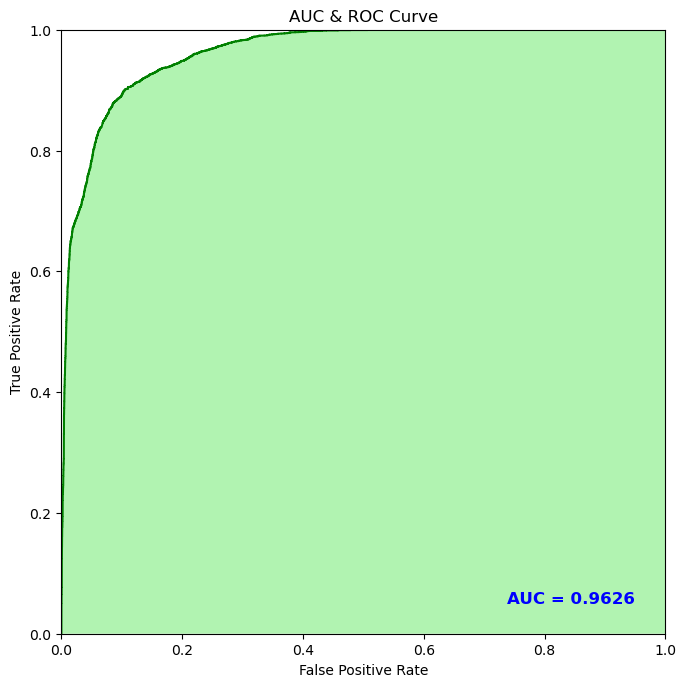

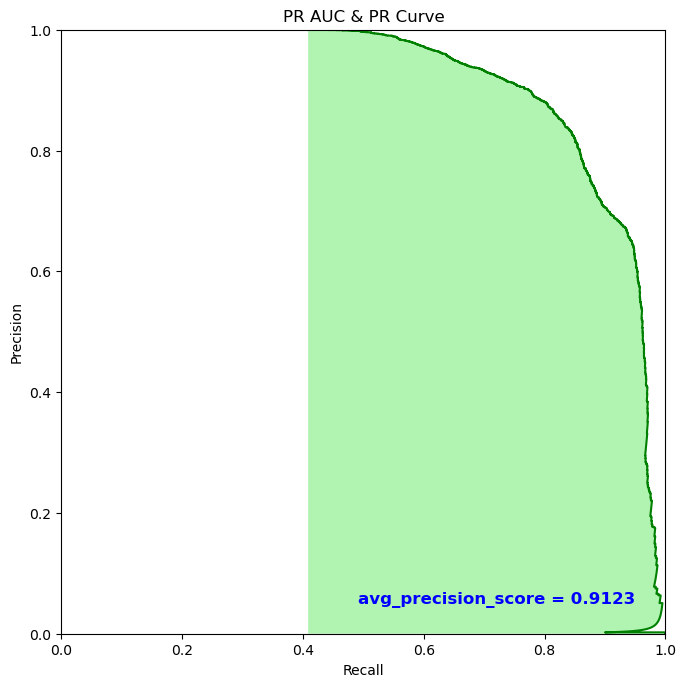

In [13]:
y_pred = sv_search.best_estimator_.predict(X_test_std)
y_prob = sv_search.best_estimator_.predict_proba(X_test_std)[:,1]

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

bas = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy Score: ", bas)

s = sv_search.best_estimator_.score(X_test_std, y_test)
print("Score: ", s)

bscore = brier_score_loss(y_test, y_prob)
print("Brier score: ", bscore)

mcc = matthews_corrcoef(y_test, y_pred)
print("Matthews corrcoef: ", mcc)

print("Classification report:\n", classification_report(y_test, y_pred))
auc = roc_auc_score(y_test, y_prob)

prauc = average_precision_score(y_test, y_prob)
precision, recall, _ = precision_recall_curve(y_test, y_prob)

false_positive_rate, true_positive_rate, thresolds = roc_curve(y_test, y_prob)

if len(true_positive_rate) < len(recall):
    tpr = np.append(true_positive_rate, (len(recall)-len(true_positive_rate)) * [None])
    fpr = np.append(false_positive_rate, (len(recall)-len(false_positive_rate)) * [None])
    tmp = pd.DataFrame.from_dict({'BAS': bas, 'simplyScore': s, 'brier': bscore, 'matthews': mcc, 'TPR' : tpr, 'FPR': fpr,
        'valAUC': auc, 'precision': precision, 'recall': recall, 'valPRAUC': prauc, 'method': 'SVM'})
    tmp = tmp.astype({'TPR': np.float64, 'FPR': np.float64})
else:
    tmp = pd.DataFrame.from_dict({'BAS': bas, 'simplyScore': s, 'brier': bscore, 'matthews': mcc, 'TPR' : true_positive_rate, 'FPR': false_positive_rate,
        'valAUC': auc, 'precision': precision, 'recall': recall, 'valPRAUC': prauc, 'method': 'SVM'})
tmp.to_csv('assets/auc_res.tsv', index = False, sep='\t', mode = 'a', header = None, float_format='%.18f')

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("PR AUC & PR Curve")
plt.plot(precision, recall, 'g')
plt.fill_between(precision, recall, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'avg_precision_score = %0.4f' % prauc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

### Neural Network

Vedi nns.ipynb